In [1]:
import scipy
import numpy as np
from sklearn.metrics import pairwise_distances
import networkx as nx
import pandas as pd

In [2]:
POINTS_ARRAY = np.random.uniform(size = (5,3))
POINTS_ARRAY

array([[0.25453477, 0.00283864, 0.00126931],
       [0.47098123, 0.2077545 , 0.52140205],
       [0.6601112 , 0.59976717, 0.72162442],
       [0.26891562, 0.2411938 , 0.59519073],
       [0.70863692, 0.7567612 , 0.63273063]])

In [3]:
distance_matrix = pairwise_distances(POINTS_ARRAY).round(2)
distance_matrix

array([[0.  , 0.6 , 1.02, 0.64, 1.08],
       [0.6 , 0.  , 0.48, 0.22, 0.61],
       [1.02, 0.48, 0.  , 0.55, 0.19],
       [0.64, 0.22, 0.55, 0.  , 0.68],
       [1.08, 0.61, 0.19, 0.68, 0.  ]])

In [4]:
mst = scipy.sparse.csgraph.minimum_spanning_tree(distance_matrix)
print(mst)

  (0, 1)	0.6
  (2, 1)	0.48
  (2, 4)	0.19
  (3, 1)	0.22


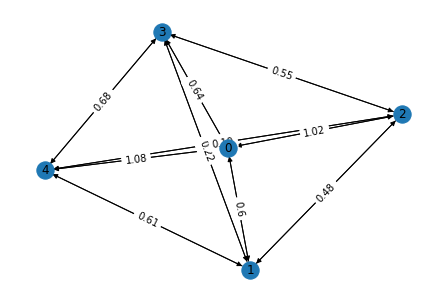

In [5]:
G = nx.from_numpy_matrix(distance_matrix, create_using=nx.DiGraph)
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels = True)
labels = nx.get_edge_attributes(G, "weight")
_ = nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

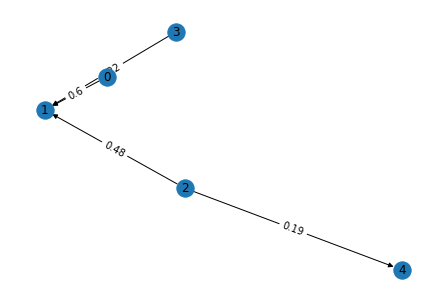

In [6]:
G = nx.from_numpy_matrix(mst.toarray(), create_using=nx.DiGraph)
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels = True)
labels = nx.get_edge_attributes(G, "weight")
_ = nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)

In [7]:
mst_cords = mst.tocoo()
mst_df = pd.DataFrame({'src':mst_cords.row, 'dst':mst_cords.col, 'dist':mst_cords.data})
mst_df = mst_df.sort_values(by='dist').reset_index(drop = True)

In [8]:
class Component:
    def __init__(self, vertices, polygon):
        self.vertices = vertices
        self.polygon = polygon

In [9]:
class NaiveDisjoinSet:
    def __init__(self, n_points):
        self.universal = [Component({i}, [(0,0), (0,0)]) for i in range(n_points)]
    def Find(self, a):
        for ele in self.universal:
            if a in ele.vertices:
                return ele
        raise Exception("Element Not Found")
    def Union(self, a, b, merged_hull):
        s1 = self.Find(a)
        s2 = self.Find(b)
        if s1.vertices == s2.vertices:
            raise Exception("Elements belong to same set")
        s3 = s1.vertices.union(s2.vertices)
        nc = Component(s3, merged_hull)
        self.universal.remove(s1)
        self.universal.remove(s2)
        self.universal.append(nc)
        
        
        
# nd = NaiveDisjoinSet(5)
# print(nd.universal[0].vertices)
# nd.Find(4).vertices
# nd.Union(1, 2, [(0,0), (0,1), (0,0)])
# nd.Find(2)
# nd.Union(3, 1)
# nd.Find(1)
# nd.Find(2)
# nd.Find(4)
# nd.Find(2)

In [10]:
# np.Inf

In [41]:
def find_angle(p1, p2, trans):
    x = p2[0] - p1[0]
    y = p2[1] - p1[1]
    n = np.sqrt(x*x + y*y)
    x = x/n
    y = y/n
    trans['cos'] = x
    trans['sin'] = np.sqrt(1 - x*x)
    if y >= 0:
        trans['sin'] = -trans['sin']
    return trans
    
    
    

In [42]:
def alignHull(hull, p1, top):
    v= -1
    d2 = np.Inf
    print(f"Before iteration v: {v} d2: {d2}")
    for i, p2 in enumerate(hull):
        d = np.linalg.norm(np.array(p1) - np.array(p2))
        if d < d2:
            v = i
            d2 = d
        print(f"Iteration {i} v: {v} d2: {d2}")
    print(f"After Iteration v: {v} d: {d2}")
    if top:
        v1 = hull[v]
        v2 = hull[v+1]
    else:
        if v == 0:
            v = -1
        v1 = hull[v]
        v2 = hull[v-1]
        
        
    print(f"v1: {v1} v2:{v2}")
    trans = {}
    trans['tx'] = -hull[v][0]
    trans['ty'] = -hull[v][1]
    print(f"trans: {trans}")
    if len(hull) > 2:
        trans = find_angle(v1, v2, trans)
    else:
        trans['sin'] = 0
        trans['cos'] = 1
    print(f"trans: {trans}")
    return trans
        
        

In [43]:
def transform(p, t, yoff):
    x = p[0] + t['tx']
    y = p[1] + t['ty']
    xx = x*t['cos'] - y*t['sin']
    yy = x*t['sin'] + y*t['cos']
    yy += yoff
    return (xx, yy)

In [44]:
def transform_component(c, t, yoff):
    global verts
    for v in c.vertices:
        verts[v] = transform(verts[v], t, yoff)
        
        
        

In [45]:
def compute_convex_hull(points):
    global verts
    convex_hull = []
    if points.shape[1] == 1:
        convex_hull.append(tuple(points[0]))
        convex_hull.append(tuple(points[0]))
    elif points.shape[1] ==2:
        convex_hull.append(tuple(points[0]))
        convex_hull.append(tuple(points[1]))
        convex_hull.append(tuple(points[0]))
    else:
        n_hull= scipy.spatial.ConvexHull(points).vertices
        n_hull.append(n_hull[0])
        convex_hull = [tuple(verts[i]) for i in n_hull]
    return convex_hull
        

In [46]:
def mergeComponents(c1_o,c2_o,v1,v2,length):
    global verts
    c1 = c1_o.vertices
    c2 = c2_o.vertices
    merged = set(list(c1)+list(c2))
    
    print(f'merged: {merged}')
    if length > 0:
        t1 = alignHull(c1_o.polygon, verts[v1], True)
        transform_component(c1_o, t1, 0)
        t2 = alignHull(c2_o.polygon, verts[v2], False)
        transform_component(c2_o, t2, length)
        points = np.array([list(verts[v]) for v in merged])
        n_hull= compute_convex_hull(points)
    else:
        raise Exception("Same co-ordinates")
    return n_hull
            
    

In [47]:
nd = NaiveDisjoinSet(len(POINTS_ARRAY))

verts = {}
for i in range(len(POINTS_ARRAY)):
    verts[i] = (0,0)
    
for i in range(len(mst_df)):
    p1 = mst_df["src"][i]
    p2 = mst_df["dst"][i]

    c1 = nd.Find(p1)
    c2 = nd.Find(p2)
    print(f"c1: {c1.vertices}  c2: {c2.vertices}")
    if c1.vertices == c2.vertices :
        print("Error")
    hull = mergeComponents(c1,c2,p1,p2,mst_df["dist"][i])
    print(hull)
    nd.Union(p1, p2, hull)
    print('-'*10)

print(verts)

c1: {2}  c2: {4}
merged: {2, 4}
Before iteration v: -1 d2: inf
Iteration 0 v: 0 d2: 0.0
Iteration 1 v: 0 d2: 0.0
After Iteration v: 0 d: 0.0
v1: (0, 0) v2:(0, 0)
trans: {'tx': 0, 'ty': 0}
trans: {'tx': 0, 'ty': 0, 'sin': 0, 'cos': 1}
Before iteration v: -1 d2: inf
Iteration 0 v: 0 d2: 0.0
Iteration 1 v: 0 d2: 0.0
After Iteration v: 0 d: 0.0
v1: (0, 0) v2:(0, 0)
trans: {'tx': 0, 'ty': 0}
trans: {'tx': 0, 'ty': 0, 'sin': 0, 'cos': 1}
[(0.0, 0.0), (0.0, 0.19), (0.0, 0.0)]
----------
c1: {3}  c2: {1}
merged: {1, 3}
Before iteration v: -1 d2: inf
Iteration 0 v: 0 d2: 0.0
Iteration 1 v: 0 d2: 0.0
After Iteration v: 0 d: 0.0
v1: (0, 0) v2:(0, 0)
trans: {'tx': 0, 'ty': 0}
trans: {'tx': 0, 'ty': 0, 'sin': 0, 'cos': 1}
Before iteration v: -1 d2: inf
Iteration 0 v: 0 d2: 0.0
Iteration 1 v: 0 d2: 0.0
After Iteration v: 0 d: 0.0
v1: (0, 0) v2:(0, 0)
trans: {'tx': 0, 'ty': 0}
trans: {'tx': 0, 'ty': 0, 'sin': 0, 'cos': 1}
[(0.0, 0.22), (0.0, 0.0), (0.0, 0.22)]
----------
c1: {2, 4}  c2: {1, 3}
merged

In [ ]:
verts

In [ ]:
nd.universal[-1].polygon

In [ ]:
nd.Find(p1)

In [ ]:
c1

In [ ]:
c1 in nd.universal